# PHE SEIR Model Inference

In this notebook we present how to use the `epimodels` module to set up the inference for some of the parameters of the model built by Public Health England in collaboration with University of Cambridge, using region specific contact matrices from Feb 2020 to Apr 2021.

In [1]:
# Load necessary libraries
import os
import numpy as np
import pandas as pd
from scipy.stats import gamma, nbinom
import epimodels as em
import matplotlib
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import pyplot as plt
from iteration_utilities import deepflatten

### Define setup matrices for the PHE Model

In [2]:
# Populate the model
total_days =  90
regions = [
    #'EE', 'London', 'Mid', 'NE', 'NW', 'SE',
    'SW']
age_groups = ['0-1', '1-5', '5-15', '15-25', '25-45', '45-65', '65-75', '75+']

weeks = list(range(1,int(np.ceil(total_days/7))+1))
matrices_region = []

### Variable
# # Initial state of the system
# for w in weeks:
#     weeks_matrices_region = []
#     for r in regions:
#         path = os.path.join('../../data/final_contact_matrices/{}_W{}.csv'.format(r, w))
#         region_data_matrix = pd.read_csv(path, header=None, dtype=np.float64)
#         #region_data_matrix_var.iloc[:, 5] = region_data_matrix_var.iloc[:, 5] * 2
#         regional = em.RegionMatrix(r, age_groups, region_data_matrix)
#         weeks_matrices_region.append(regional)
# 
#     matrices_region.append(weeks_matrices_region)
# 
# contacts = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
# matrices_contact = [contacts]
# 
# # Matrices contact
# time_changes_contact = [1]
# time_changes_region = np.arange(1, total_days+1, 7).tolist()

### Fixed
# Initial state of the system
weeks_matrices_region = []
for r in regions:
    path = os.path.join('../../data/final_contact_matrices/BASE.csv')
    region_data_matrix = pd.read_csv(path, header=None, dtype=np.float64)
    regional = em.RegionMatrix(r, age_groups, region_data_matrix)
    #region_data_matrix_fix.iloc[:, 5] = region_data_matrix_fix.iloc[:, 5] * 2
    weeks_matrices_region.append(regional)

matrices_region.append(weeks_matrices_region)

contacts = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
matrices_contact = [contacts]

# Matrices contact
time_changes_contact = [1]
time_changes_region = [1]

### Set the parameters and initial conditions of the model and bundle everything together to simulate

In [3]:
# Instantiate model
model = em.PheSEIRModel()

# Set the region names, contact and regional data of the model
model.set_regions(regions)
model.read_contact_data(matrices_contact, time_changes_contact)
model.read_regional_data(matrices_region, time_changes_region)

# Initial number of susceptibles
susceptibles = [
    #[68124, 299908, 773741, 668994, 1554740, 1632059, 660187, 578319],
    #[117840, 488164, 1140597, 1033029, 3050671, 2050173, 586472, 495043],
    #[116401, 508081, 1321675, 1319046, 2689334, 2765974, 1106091, 943363],
    #[85845, 374034, 978659, 1005275, 2036049, 2128261, 857595, 707190],
    #[81258, 348379, 894662, 871907, 1864807, 1905072, 750263, 624848],
    #[95825, 424854, 1141632, 1044242, 2257437, 2424929, 946459, 844757],
    [53565, 237359, 641486, 635602, 1304264, 1499291, 668999, 584130]]

#infectives1 = (10 * np.ones((len(regions), len(age_groups)))).tolist()
#infectives1 = (1 * np.ones((len(regions), len(age_groups)))).tolist()
infectives1 = [
    #[0, 0, 0, 0, 0, 1, 0, 0],
    #[0, 0, 0, 0, 2, 0, 0, 0],
    #[0, 0, 0, 0, 0, 0, 1, 0],
    #[0, 0, 0, 0, 1, 0, 0, 0],
    #[0, 0, 0, 0, 0, 1, 0, 0],
    #[0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0]]
infectives2 = np.zeros((len(regions), len(age_groups))).tolist()

dI = 4
dL = 4

# Initial R number by region
#psis = gamma.rvs(31.36, scale=1/224, size=len(regions))
psis = (31.36/224)*np.ones(len(regions))
initial_r = np.multiply(dI*psis, np.divide(np.square((dL/2)*psis+1), 1 - 1/np.square((dI/2)*psis+1)))

# List of times at which we wish to evaluate the states of the compartments of the model
times = np.arange(1, total_days+1, 1).tolist()

# Simulate for all regions
output_scipy_solver = []
new_infec_scipy_solver = []

for r, reg in enumerate(regions):
    # List of common initial conditions and parameters that characterise the fixed and variable model
    parameters = [
        initial_r, r+1, susceptibles, np.zeros((len(regions), len(age_groups))).tolist(), np.zeros((len(regions), len(age_groups))).tolist(),
        infectives1, infectives2, np.zeros((len(regions), len(age_groups))).tolist(), np.ones((len(regions), len(times))).tolist(), dL, dI, 0.5]

    # Simulate using the ODE solver from scipy
    scipy_method = 'RK45'
    parameters.append(scipy_method)

    output_scipy_solver.append(model.simulate(list(deepflatten(parameters, ignore=str)), times))
    new_infec_scipy_solver.append(model.new_infections(output_scipy_solver[-1]))

In [4]:
initial_r

array([2.35469698])

### Inference procedure

In [5]:
td_mean = 15.0
td_var = 12.1**2
theta = td_var / td_mean
k = td_mean / theta
time_to_death = gamma(k, scale=theta).pdf(np.arange(1, 31)).tolist()

# Set information
fatality_ratio = (1/100 * np.array([0.0016, 0.0016, 0.0043, 0.019, 0.08975, 0.815, 3.1, 6.05])).tolist()
time_to_death.extend([0.0] * (len(times)-30))
niu = float(gamma.rvs(1, scale=1/0.2, size=1))

tests = [np.array([[1000] * len(age_groups)] * len(times))] * len(regions)
sens = 0.7
spec = 0.95


In [6]:
fatality_ratio

[1.6000000000000003e-05,
 1.6000000000000003e-05,
 4.3e-05,
 0.00019,
 0.0008975,
 0.00815,
 0.031000000000000003,
 0.0605]

In [7]:
# Sample death and positive test results data for all regions
deaths_data = []
positives_data = []

for r, reg in enumerate(regions):
    reg_deaths_data = np.empty((len(times), len(age_groups)))
    reg_positives_data = np.empty(((len(times), len(age_groups))))
    for t, _ in enumerate(times):
        reg_deaths_data[t, :] = model.samples_deaths(new_infec_scipy_solver[r], fatality_ratio, time_to_death, niu, t)
        reg_positives_data[t, :] = model.samples_positive_tests(output_scipy_solver[r], tests[r][t, :], sens, spec, t)
    deaths_data.append(np.asarray(reg_deaths_data, dtype=int))
    positives_data.append(np.asarray(reg_positives_data, dtype=int))


In [8]:
# Export death and positive test results data for all regions to external files to save computation time
path_ = 'inference_data/'

for r, region in enumerate(regions):
    path = os.path.join(path_, '{}_Deaths.csv'.format(region))
    path1 = os.path.join(path_, '{}_Positives.csv'.format(region))

    np.savetxt(path, deaths_data[r], fmt="%d", delimiter=',')
    np.savetxt(path1, positives_data[r], fmt="%d",  delimiter=',')

### Run Inference for the Initial R Numbers

In [9]:
# Read in death and positive data from external files
deaths_data = []
positives_data = []

for region in regions:
    deaths_data.append(np.loadtxt('inference_data/{}_Deaths.csv'.format(region), dtype=int, delimiter=','))
    positives_data.append(np.loadtxt('inference_data/{}_Positives.csv'.format(region), dtype=int, delimiter=','))

In [22]:
# Initialise inference for the model
phe_inference = em.PheSEIRInfer(model)

# Add death and tests data to the inference structure
phe_inference.read_deaths_data(deaths_data, time_to_death)
phe_inference.read_serology_data(tests, positives_data, sens, spec)

# Run inference structure
samples = phe_inference.inference_problem_setup(times, num_iter=60000)

Running...
Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval.  Accept.   Accept.   Accept.   Time m:s
0     3       0         0         0          0:00.3
1     6       0         0.5       0.5        0:00.5
2     9       0.333     0.333     0.333      0:00.7
3     12      0.5       0.25      0.5        0:00.8
20    63      0.238     0.429     0.286      0:03.2
40    123     0.122     0.293     0.171      0:06.0
60    183     0.082     0.213     0.131      0:08.8
80    243     0.0617    0.16      0.111      0:11.5
100   303     0.0594    0.168     0.099      0:14.3
120   363     0.0579    0.157     0.0909     0:16.9
140   423     0.0496    0.149     0.0993     0:19.6
160   483     0.0435    0.13      0.087      0:22.2
180   543     0.0387    0.121547  0.0829     0:24.8
Initial phase completed.
200   603     0.0448    0.109     0.0746     0:27.5
220   663     0.0588    0.127     0.095      0:30.2
240   723     0.104     0.162     0.

### Plot the histogram and trajectories of the MCMC sampler chain values

In [23]:
pints.rhat(samples)

array([1.00169182, 1.03412407, 1.03876413, 1.0134366 , 1.00511973,
       1.00095877, 1.00399899, 1.00585275, 1.0054063 ])

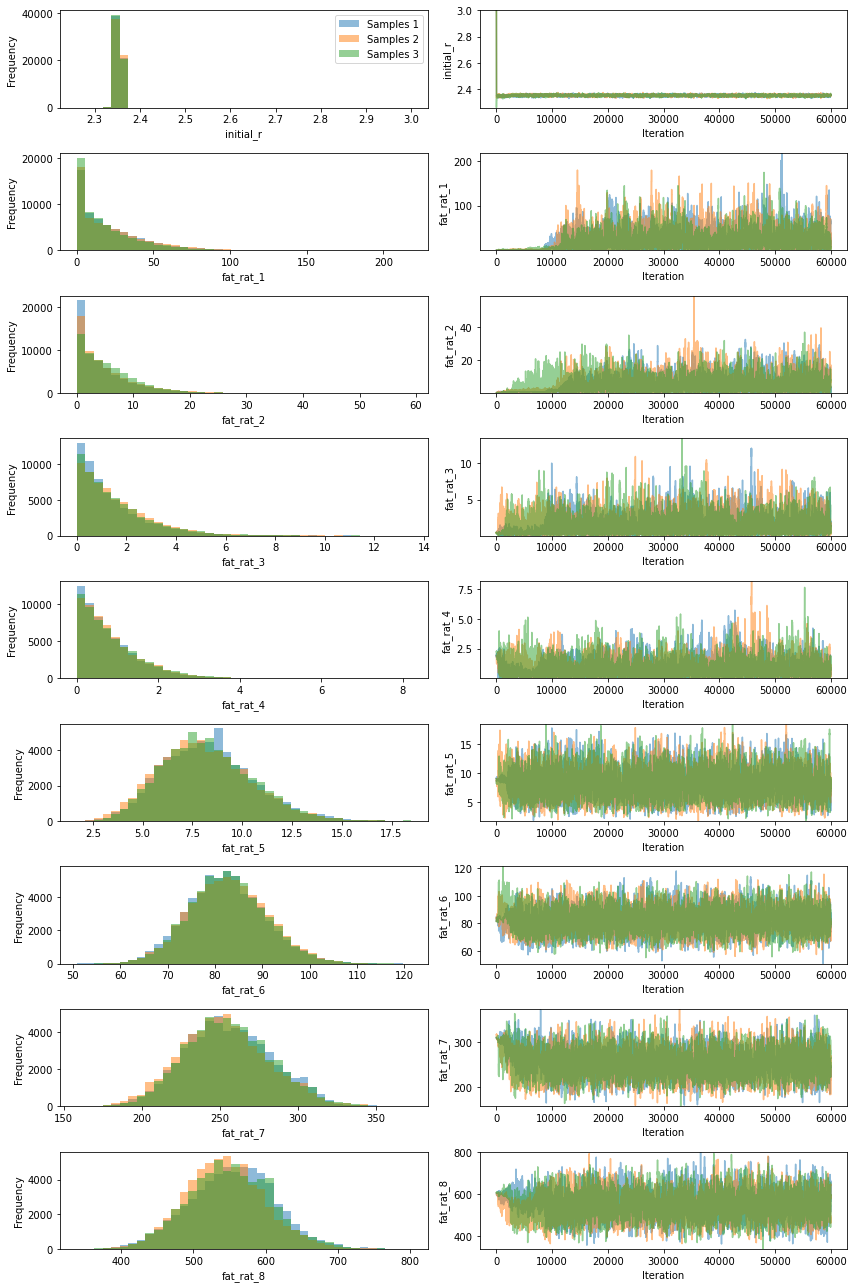

In [24]:
import pints.plot

param_names = ['initial_r']
param_names.extend(['fat_rat_{}'.format(i+1) for i in range(len(age_groups))])

pints.plot.trace(samples, parameter_names=param_names)
plt.show()

In [25]:
samples = samples[:, 30000:, :]

In [26]:
pints.rhat(samples)

array([1.00168084, 1.00485397, 1.00304527, 1.00307573, 1.00340218,
       1.00154329, 1.00207497, 1.005091  , 1.00155227])

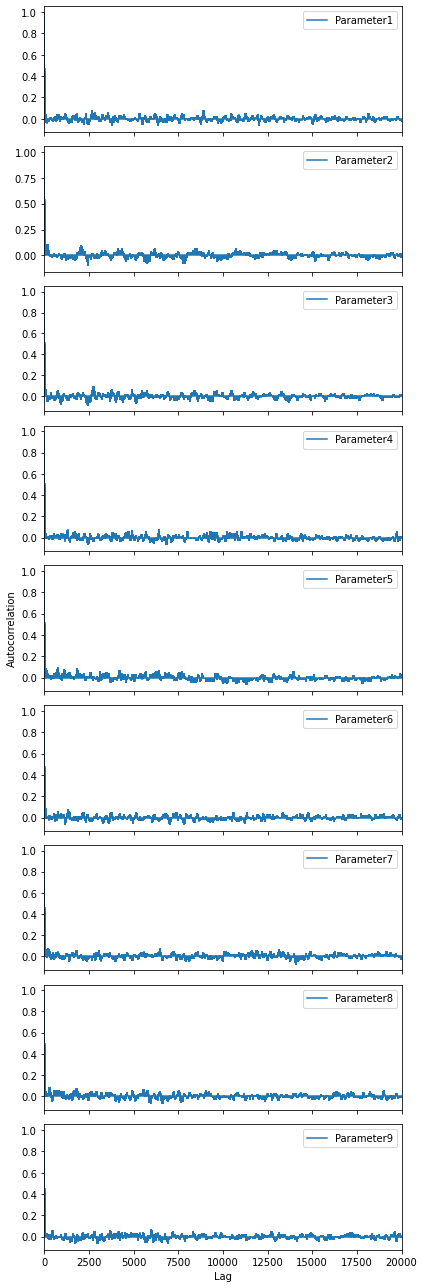

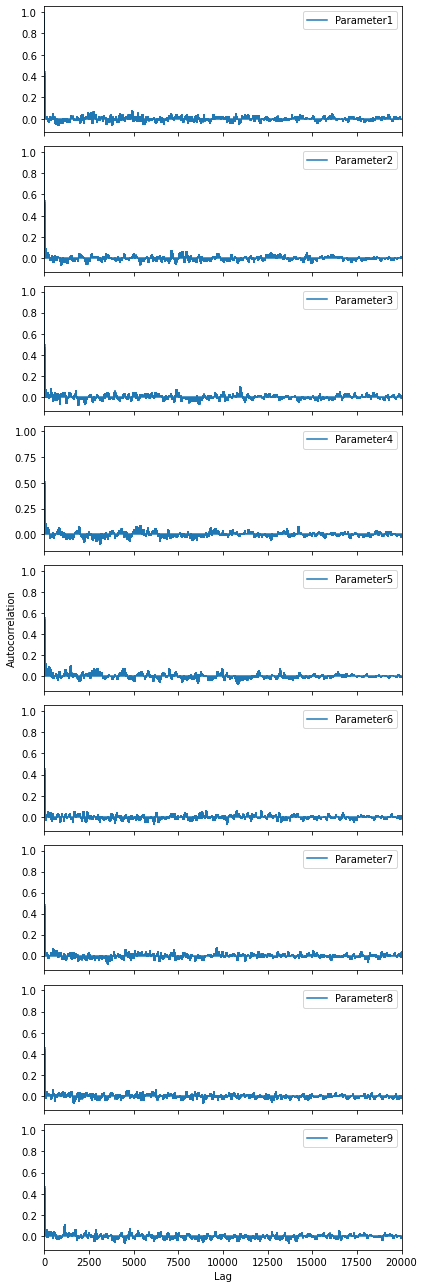

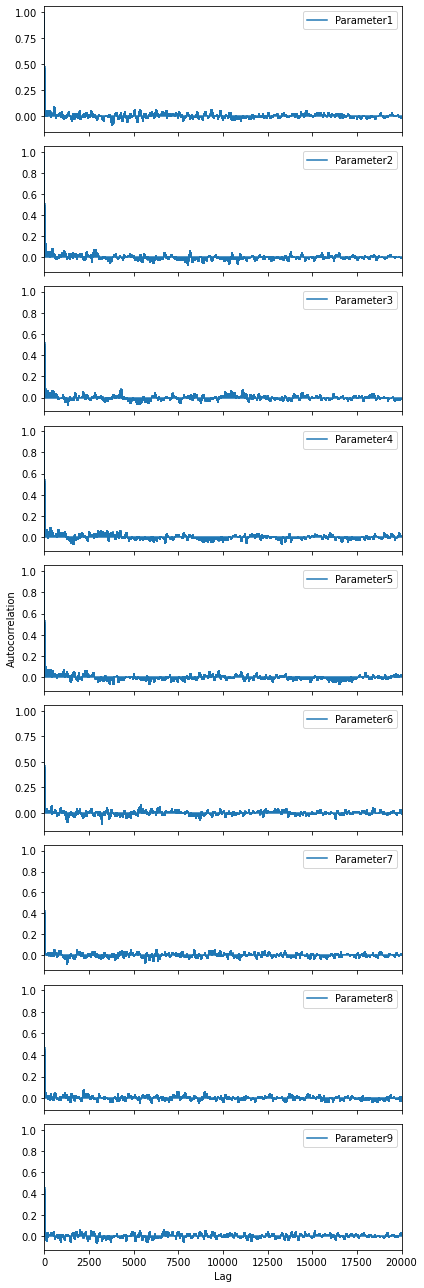

In [27]:
for sample in samples:
    pints.plot.autocorrelation(sample, max_lags=20000)
    plt.show()

### Thin out the MCMC samples (by 10) and run model for the sampled parameter choices to compute the expected number of deaths, new infections and the reproduction number

In [150]:
# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = samples.shape

extended_samples = np.concatenate((samples[0], samples[1], samples[2]), axis=0)

thinning = max(1, int(n_sample * n_chains / 9000))

n_parameters = model.n_parameters()

predicted_new_infec = []
predicted_deaths = []
predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(model.regions):
    reg_predicted_new_infec = []
    reg_predicted_deaths = []
    reg_predicted_reprod_num = []

    parameters[1] = r+1

    for params in extended_samples[::thinning, :n_parameters]:
        parameters[0] = [params[0]] * len(model.regions)
        fatality_ratio = (np.asarray(params[1:]) * 10**(-4)).tolist()

        r_fix = np.empty(len(times))
        model_reg_deaths_data = np.empty(len(times))

        m_fix = em.MultiTimesInfectivity(
            matrices_contact, time_changes_contact, regions, matrices_region, time_changes_region, parameters[0], parameters[10], parameters[2])

        # Run model and number of new infections for all age groups
        model_output = model.simulate(
            parameters=list(deepflatten(parameters, ignore=str)),
            times=times
        )
        age_model_reg_new_infections = model.new_infections(model_output)
        model_reg_new_infections = age_model_reg_new_infections.sum(axis=1)

        for t, time in enumerate(times):
            r_fix[t] = m_fix.compute_reproduction_number(r+1, time, model_output[t, :len(age_groups)])
            model_reg_deaths_data[t] = np.sum(model.mean_deaths(fatality_ratio, time_to_death, t, age_model_reg_new_infections))

        reg_predicted_new_infec.append(model_reg_new_infections)
        reg_predicted_deaths.append(model_reg_deaths_data)
        reg_predicted_reprod_num.append(r_fix)

    reg_predicted_new_infec = np.array(reg_predicted_new_infec)

    predicted_new_infec.append(reg_predicted_new_infec)
    predicted_deaths.append(reg_predicted_deaths)
    predicted_reprod_num.append(reg_predicted_reprod_num)

predicted_new_infec = np.array(predicted_new_infec)
predicted_deaths = np.array(predicted_deaths)
predicted_reprod_num = np.array(predicted_reprod_num)


### Plot the mean and CI bounds of the trajectories of interest

In [151]:
# Set up traces to plot
new_infec_mean = []
deaths_mean = []
reprod_num_mean = []

new_infec_upper = []
deaths_upper = []
reprod_num_upper = []

new_infec_lower = []
deaths_lower = []
reprod_num_lower = []

for r, _ in enumerate(model.regions):
    # Compute the mean 
    new_infec_mean.append(np.mean(predicted_new_infec[r,:,:], axis=0))
    deaths_mean.append(np.mean(predicted_deaths[r,:,:], axis=0))
    reprod_num_mean.append(np.mean(predicted_reprod_num[r,:,:], axis=0))

    # Compute the upper quantiles
    new_infec_upper.append(np.quantile(predicted_new_infec[r,:,:], 0.975, axis=0))
    deaths_upper.append(np.quantile(predicted_deaths[r,:,:], 0.975, axis=0))
    reprod_num_upper.append(np.quantile(predicted_reprod_num[r,:,:], 0.975, axis=0))

    # Compute the lower qunatiles
    new_infec_lower.append(np.quantile(predicted_new_infec[r,:,:], 0.025, axis=0))
    deaths_lower.append(np.quantile(predicted_deaths[r,:,:], 0.025, axis=0))
    reprod_num_lower.append(np.quantile(predicted_reprod_num[r,:,:], 0.025, axis=0))

In [153]:
from plotly.subplots import make_subplots

colours = ['blue', 'red', 'green', 'purple', 'orange', 'black', 'gray', 'pink']

# Group outputs together
outputs = [deaths_data, positives_data]

# Number of regions
n_reg = len(regions)

In [173]:
# Trace names - represent the solver used for the simulation
trace_name = regions
titles = ['Infections', 'Deaths', 'Reproduction Number']

fig = go.Figure()
fig = make_subplots(rows=len(titles), cols=1, subplot_titles=tuple(titles), horizontal_spacing = 0.15)

# Plot (bar chart cases each day)
for r, region in enumerate(regions):
    # Plot of infections
    fig.add_trace(
        go.Scatter(
            x=times,
            y=new_infec_mean[r].tolist(),
            mode='lines',
            name=trace_name[r],
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=new_infec_upper[r].tolist() + new_infec_lower[r].tolist()[::-1],
            fill='toself',
            fillcolor=colours[r],
            line_color=colours[r],
            opacity=0.15,
            mode='lines',
            showlegend=False,
            name=trace_name[r]
        ),
        row= 1,
        col= 1
    )

    # Plot deaths
    fig.add_trace(
        go.Scatter(
            x=times,
            y=deaths_mean[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=deaths_upper[r].tolist() + deaths_lower[r].tolist()[::-1],
            fill='toself',
            fillcolor=colours[r],
            line_color=colours[r],
            opacity=0.15,
            mode='lines',
            showlegend=False,
            name=trace_name[r]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times,
            y=np.sum(deaths_data[r], axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    # Plot reproduction number
    fig.add_trace(
        go.Scatter(
            x=times,
            y=reprod_num_mean[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 3,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=reprod_num_upper[r].tolist() + reprod_num_lower[r].tolist()[::-1],
            fill='toself',
            fillcolor=colours[r],
            line_color=colours[r],
            opacity=0.15,
            mode='lines',
            showlegend=False,
            name=trace_name[r]
        ),
        row= 3,
        col= 1
    )

# Add axis labels
fig.update_layout(
    width=600, 
    height=900,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(1, 93, 10).tolist(),
        ticktext=['Mar 01', 'Mar 11', 'Mar 21', 'Mar 31', 'Apr 09', 'Apr 19', 'Apr 29', 'May 09', 'May 19', 'May 29']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(1, 93, 10).tolist(),
        ticktext=['Mar 01', 'Mar 11', 'Mar 21', 'Mar 31', 'Apr 09', 'Apr 19', 'Apr 29', 'May 09', 'May 19', 'May 29']),
    yaxis2=dict(linecolor='black'),
    xaxis3=dict(
        linecolor='black',
        tickvals=np.arange(1, 93, 10).tolist(),
        ticktext=['Mar 01', 'Mar 11', 'Mar 21', 'Mar 31', 'Apr 09', 'Apr 19', 'Apr 29', 'May 09', 'May 19', 'May 29']),
    yaxis3=dict(linecolor='black'),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.075,
        xanchor="right",
        x=1)
    )

fig.write_image('images/Figure-2-synthetic.pdf')
fig.show()

In [ ]:
loglik_arr = np.empty(25)

for ind_di, di in enumerate(np.linspace(3.5,4.5, 25)):
    loglik_arr[ind_di] = phe_inference.return_loglikelihood(times, [2.35469698, di])

ValueError: Wrong number of age groups for fatality ratios.

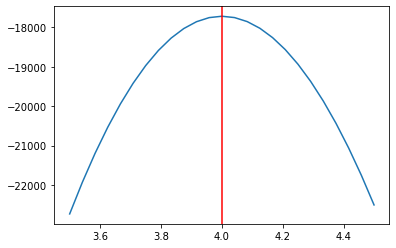

In [ ]:
plt.plot(np.linspace(3.5,4.5, 25), loglik_arr)

plt.axvline(x=4, c='r')

In [ ]:
loglik_arr = np.empty(25)

for ind_r, r in enumerate(np.linspace(2,3, 25)):
    loglik_arr[ind_r] = phe_inference.return_loglikelihood(times, [r, dI])

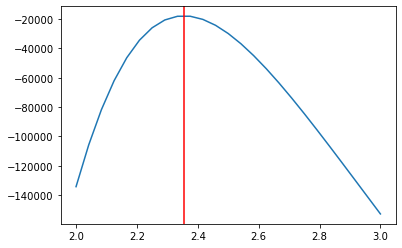

In [ ]:
plt.plot(np.linspace(2,3, 25), loglik_arr)

plt.axvline(x=2.35469698, c='r')

In [ ]:
loglik_arr = np.empty((25,25))

for ind_di, di in enumerate(np.linspace(3.5,4.5, 25)):
    for ind_r, r in enumerate(np.linspace(2,3, 25)):
        loglik_arr[ind_di, ind_r] = phe_inference.return_loglikelihood(times, [r, di])

In [ ]:
plt.imshow(loglik_arr, cmap='viridis', extent=[3.5,4.5,3,2])
# plt.plot(loglik_arr)

plt.colorbar()
plt.scatter(4, 2.35469698, c='r')
plt.show()

NameError: name 'loglik_arr' is not defined

## Simulate number of deaths and positive tests for different initial_r

In [ ]:
# Initial R number by region
#psis = gamma.rvs(31.36, scale=1/224, size=len(regions))
psis = (31.36/224)*np.ones(len(regions))
initial_rs0 = np.multiply(dI*psis, np.divide(np.square((dL/2)*psis+1), 1 - 1/np.square((dI/2)*psis+1)))
initial_rs = initial_rs0 + np.linspace(-0.5,0.5,num=8)

# List of times at which we wish to evaluate the states of the compartments of the model
times = np.arange(1, total_days+1, 1).tolist()

# Simulate for all regions
deaths_data = []
positives_data = []

for ir, initial_r in enumerate(initial_rs):
    for r, reg in enumerate(regions):
        # List of common initial conditions and parameters that characterise the fixed and variable model
        parameters = [
            initial_r, r+1, susceptibles, np.zeros((len(regions), len(age_groups))).tolist(), np.zeros((len(regions), len(age_groups))).tolist(),
            infectives1, infectives2, np.zeros((len(regions), len(age_groups))).tolist(), np.ones((len(regions), len(times))).tolist(), dL, dI, 0.5]

        # Simulate using the ODE solver from scipy
        scipy_method = 'RK45'
        parameters.append(scipy_method)

        output_scipy_solver = model.simulate(list(deepflatten(parameters, ignore=str)), times)
        new_infec_scipy_solver = model.new_infections(output_scipy_solver)

        reg_deaths_data = np.empty((len(times), len(age_groups)))
        reg_positives_data = np.empty(((len(times), len(age_groups))))
        for t, _ in enumerate(times):
            reg_deaths_data[t, :] = model.mean_deaths(fatality_ratio, time_to_death, t, new_infec_scipy_solver)
            reg_positives_data[t, :] = model.samples_positive_tests(output_scipy_solver, tests[r][t, :], sens, spec, t)
        deaths_data.append(np.asarray(reg_deaths_data, dtype=int))
        positives_data.append(np.asarray(reg_positives_data, dtype=int))

In [ ]:
# Trace names - represent the solver used for the simulation
trace_name = ['Initial R = {}'.format(initial_r) for initial_r in initial_rs]

fig = go.Figure()

fig = make_subplots(
    rows=int(np.ceil((len(age_groups)+1)/2)), cols=2, subplot_titles=tuple(['ages {}'.format(age) for age in age_groups] + ['Total'])
)

# Plot (bar chart cases each day)
for ir, initial_r in enumerate(initial_rs):
    for a, age in enumerate(age_groups):
        if a == 0: 
            fig.add_trace(
                go.Scatter(
                    x=times[1:],
                    y=deaths_data[ir][:, a].tolist(),
                    line_color=colours[ir],
                    name=trace_name[ir]
                ),
                row= int(np.floor(a / 2)) + 1,
                col= a % 2 + 1
            )

        else:
            fig.add_trace(
                go.Scatter(
                    x=times[1:],
                    y=deaths_data[ir][:, a].tolist(),
                    showlegend=False,
                    line_color=colours[ir],
                    name=trace_name[ir]
                ),
                row= int(np.floor(a / 2)) + 1,
                col= a % 2 + 1
            )

    fig.add_trace(
        go.Scatter(
            x=times[1:],
            y=deaths_data[ir].sum(axis=1).tolist(),
            showlegend=False,
            line_color=colours[ir],
            name=trace_name[ir]
        ),
        row= int(np.ceil((len(age_groups)+1)/2)),
        col= 1
    )

# Add axis labels
fig.update_layout(
    boxmode='group',
    title='Age group comparison of total number of deaths in England', 
    height=1200,
    width=1000,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(3, total_days, 61).tolist(),
        ticktext=['Feb 20', 'Apr 20', 'Jun 20', 'Aug 20', 'Oct 20', 'Dec 20', 'Feb 21', 'Apr 21', 'Jun 21']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(3, total_days, 61).tolist(),
        ticktext=['Feb 20', 'Apr 20', 'Jun 20', 'Aug 20', 'Oct 20', 'Dec 20', 'Feb 21', 'Apr 21', 'Jun 21']),
    yaxis2=dict(linecolor='black'),
    xaxis3=dict(
        linecolor='black',
        tickvals=np.arange(3, total_days, 61).tolist(),
        ticktext=['Feb 20', 'Apr 20', 'Jun 20', 'Aug 20', 'Oct 20', 'Dec 20', 'Feb 21', 'Apr 21', 'Jun 21']),
    yaxis3=dict(linecolor='black'),
    xaxis4=dict(
        linecolor='black',
        tickvals=np.arange(3, total_days, 61).tolist(),
        ticktext=['Feb 20', 'Apr 20', 'Jun 20', 'Aug 20', 'Oct 20', 'Dec 20', 'Feb 21', 'Apr 21', 'Jun 21']),
    yaxis4=dict(linecolor='black'),
    xaxis5=dict(
        linecolor='black',
        tickvals=np.arange(3, total_days, 61).tolist(),
        ticktext=['Feb 20', 'Apr 20', 'Jun 20', 'Aug 20', 'Oct 20', 'Dec 20', 'Feb 21', 'Apr 21', 'Jun 21']),
    yaxis5=dict(linecolor='black'),
    xaxis6=dict(
        linecolor='black',
        tickvals=np.arange(3, total_days, 61).tolist(),
        ticktext=['Feb 20', 'Apr 20', 'Jun 20', 'Aug 20', 'Oct 20', 'Dec 20', 'Feb 21', 'Apr 21', 'Jun 21']),
    yaxis6=dict(linecolor='black'),
    xaxis7=dict(
        linecolor='black',
        tickvals=np.arange(3, total_days, 61).tolist(),
        ticktext=['Feb 20', 'Apr 20', 'Jun 20', 'Aug 20', 'Oct 20', 'Dec 20', 'Feb 21', 'Apr 21', 'Jun 21']),
    yaxis7=dict(linecolor='black'),
    xaxis8=dict(
        linecolor='black',
        tickvals=np.arange(3, total_days, 61).tolist(),
        ticktext=['Feb 20', 'Apr 20', 'Jun 20', 'Aug 20', 'Oct 20', 'Dec 20', 'Feb 21', 'Apr 21', 'Jun 21']),
    yaxis8=dict(linecolor='black'),
    xaxis9=dict(
        linecolor='black',
        tickvals=np.arange(3, total_days, 61).tolist(),
        ticktext=['Feb 20', 'Apr 20', 'Jun 20', 'Aug 20', 'Oct 20', 'Dec 20', 'Feb 21', 'Apr 21', 'Jun 21']),
    yaxis9=dict(linecolor='black'))

fig.write_image('images/Deaths_r.pdf')
fig.show()

## Simulate number of deaths and positive tests for different d_I

In [ ]:
# Initial R number by region
#psis = gamma.rvs(31.36, scale=1/224, size=len(regions))
psis = (31.36/224)*np.ones(len(regions))
initial_r = np.multiply(dI*psis, np.divide(np.square((dL/2)*psis+1), 1 - 1/np.square((dI/2)*psis+1)))
dIs = dI + np.linspace(-0.5,0.5,num=8)

# List of times at which we wish to evaluate the states of the compartments of the model
times = np.arange(1, total_days+1, 1).tolist()

# Simulate for all regions
deaths_data = []
positives_data = []

for id, d_i in enumerate(dIs):
    for r, reg in enumerate(regions):
        # List of common initial conditions and parameters that characterise the fixed and variable model
        parameters = [
            initial_r, r+1, susceptibles, np.zeros((len(regions), len(age_groups))).tolist(), np.zeros((len(regions), len(age_groups))).tolist(),
            infectives1, infectives2, np.zeros((len(regions), len(age_groups))).tolist(), np.ones((len(regions), len(times))).tolist(), dL, d_i, 0.5]

        # Simulate using the ODE solver from scipy
        scipy_method = 'RK45'
        parameters.append(scipy_method)

        output_scipy_solver = model.simulate(list(deepflatten(parameters, ignore=str)), times)
        new_infec_scipy_solver = model.new_infections(output_scipy_solver)

        reg_deaths_data = np.empty((len(times), len(age_groups)))
        reg_positives_data = np.empty(((len(times), len(age_groups))))
        for t, _ in enumerate(times):
            reg_deaths_data[t, :] = model.mean_deaths(fatality_ratio, time_to_death, t, new_infec_scipy_solver)
            reg_positives_data[t, :] = model.samples_positive_tests(output_scipy_solver, tests[r][t, :], sens, spec, t)
        deaths_data.append(np.asarray(reg_deaths_data, dtype=int))
        positives_data.append(np.asarray(reg_positives_data, dtype=int))

In [ ]:
# Trace names - represent the solver used for the simulation
trace_name = ['dI = {}'.format(d_i) for d_i in dIs]

fig = go.Figure()

fig = make_subplots(
    rows=int(np.ceil((len(age_groups)+1)/2)), cols=2, subplot_titles=tuple(['ages {}'.format(age) for age in age_groups] + ['Total'])
)

# Plot (bar chart cases each day)
for id, d_i in enumerate(dIs):
    for a, age in enumerate(age_groups):
        if a == 0: 
            fig.add_trace(
                go.Scatter(
                    x=times[1:],
                    y=deaths_data[id][:, a].tolist(),
                    line_color=colours[id],
                    name=trace_name[id]
                ),
                row= int(np.floor(a / 2)) + 1,
                col= a % 2 + 1
            )

        else:
            fig.add_trace(
                go.Scatter(
                    x=times[1:],
                    y=deaths_data[id][:, a].tolist(),
                    showlegend=False,
                    line_color=colours[id],
                    name=trace_name[id]
                ),
                row= int(np.floor(a / 2)) + 1,
                col= a % 2 + 1
            )

    fig.add_trace(
        go.Scatter(
            x=times[1:],
            y=deaths_data[id].sum(axis=1).tolist(),
            showlegend=False,
            line_color=colours[id],
            name=trace_name[id]
        ),
        row= int(np.ceil((len(age_groups)+1)/2)),
        col= 1
    )

# Add axis labels
fig.update_layout(
    boxmode='group',
    title='Age group comparison of total number of deaths in England', 
    height=1200,
    width=1000,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(3, total_days, 61).tolist(),
        ticktext=['Feb 20', 'Apr 20', 'Jun 20', 'Aug 20', 'Oct 20', 'Dec 20', 'Feb 21', 'Apr 21', 'Jun 21']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(3, total_days, 61).tolist(),
        ticktext=['Feb 20', 'Apr 20', 'Jun 20', 'Aug 20', 'Oct 20', 'Dec 20', 'Feb 21', 'Apr 21', 'Jun 21']),
    yaxis2=dict(linecolor='black'),
    xaxis3=dict(
        linecolor='black',
        tickvals=np.arange(3, total_days, 61).tolist(),
        ticktext=['Feb 20', 'Apr 20', 'Jun 20', 'Aug 20', 'Oct 20', 'Dec 20', 'Feb 21', 'Apr 21', 'Jun 21']),
    yaxis3=dict(linecolor='black'),
    xaxis4=dict(
        linecolor='black',
        tickvals=np.arange(3, total_days, 61).tolist(),
        ticktext=['Feb 20', 'Apr 20', 'Jun 20', 'Aug 20', 'Oct 20', 'Dec 20', 'Feb 21', 'Apr 21', 'Jun 21']),
    yaxis4=dict(linecolor='black'),
    xaxis5=dict(
        linecolor='black',
        tickvals=np.arange(3, total_days, 61).tolist(),
        ticktext=['Feb 20', 'Apr 20', 'Jun 20', 'Aug 20', 'Oct 20', 'Dec 20', 'Feb 21', 'Apr 21', 'Jun 21']),
    yaxis5=dict(linecolor='black'),
    xaxis6=dict(
        linecolor='black',
        tickvals=np.arange(3, total_days, 61).tolist(),
        ticktext=['Feb 20', 'Apr 20', 'Jun 20', 'Aug 20', 'Oct 20', 'Dec 20', 'Feb 21', 'Apr 21', 'Jun 21']),
    yaxis6=dict(linecolor='black'),
    xaxis7=dict(
        linecolor='black',
        tickvals=np.arange(3, total_days, 61).tolist(),
        ticktext=['Feb 20', 'Apr 20', 'Jun 20', 'Aug 20', 'Oct 20', 'Dec 20', 'Feb 21', 'Apr 21', 'Jun 21']),
    yaxis7=dict(linecolor='black'),
    xaxis8=dict(
        linecolor='black',
        tickvals=np.arange(3, total_days, 61).tolist(),
        ticktext=['Feb 20', 'Apr 20', 'Jun 20', 'Aug 20', 'Oct 20', 'Dec 20', 'Feb 21', 'Apr 21', 'Jun 21']),
    yaxis8=dict(linecolor='black'),
    xaxis9=dict(
        linecolor='black',
        tickvals=np.arange(3, total_days, 61).tolist(),
        ticktext=['Feb 20', 'Apr 20', 'Jun 20', 'Aug 20', 'Oct 20', 'Dec 20', 'Feb 21', 'Apr 21', 'Jun 21']),
    yaxis9=dict(linecolor='black'))

fig.write_image('images/Deaths_dI.pdf')
fig.show()

### Contribution of the different data components to the likelihood

In [ ]:
# Contribution of only deaths
loglik_arr_deaths = np.empty((25,25))

for ind_di, di in enumerate(np.linspace(3.5,4.5, 25)):
    for ind_r, r in enumerate(np.linspace(2,3, 25)):
        loglik_arr_deaths[ind_di, ind_r] = phe_inference.return_loglikelihood(times, [r, di], 1, 0)

# Contribution of only positives
loglik_arr_positives = np.empty((25,25))

for ind_di, di in enumerate(np.linspace(3.5,4.5, 25)):
    for ind_r, r in enumerate(np.linspace(2,3, 25)):
        loglik_arr_positives[ind_di, ind_r] = phe_inference.return_loglikelihood(times, [r, di], 0, 1)

In [ ]:
# Trace names - represent the solver used for the simulation
fig = go.Figure()

fig = make_subplots(
    rows=1, cols=3, subplot_titles=tuple(['Just Deaths', 'Just Positives', 'Total'])
)

# Plot (bar chart cases each day)
fig.add_trace(
    go.Heatmap(
        x=np.linspace(3.5,4.5, 25),
        y=np.linspace(2,3, 25),
        z=loglik_arr_deaths,
        type = 'heatmap',
        coloraxis= 'coloraxis'
    ),
    row= 1,
    col= 1
)

fig.add_trace(
    go.Scatter(
        x=[4],
        y=[2.35469698],
        mode='markers',
        marker=dict(color='red'),
        showlegend=False,
    ),
    row= 1,
    col= 1
)

fig.add_trace(
    go.Heatmap(
        x=np.linspace(3.5,4.5, 25),
        y=np.linspace(2,3, 25),
        z=loglik_arr_positives,
        type = 'heatmap',
        coloraxis='coloraxis',
    ),
    row= 1,
    col= 2
)

fig.add_trace(
    go.Scatter(
        x=[4],
        y=[2.35469698],
        mode='markers',
        marker=dict(color='red'),
        showlegend=False
    ),
    row= 1,
    col= 2
)

fig.add_trace(
    go.Heatmap(
        x=np.linspace(3.5,4.5, 25),
        y=np.linspace(2,3, 25),
        z=loglik_arr,
        type = 'heatmap',
        coloraxis='coloraxis',
    ),
    row= 1,
    col= 3
)

fig.add_trace(
    go.Scatter(
        x=[4],
        y=[2.35469698],
        mode='markers',
        marker=dict(color='red'),
        showlegend=False
    ),
    row= 1,
    col= 3
)

# Add axis labels
fig.update_layout(
    boxmode='group',
    title='Contributions to log-likelihood', 
    height=400,
    width=1200,
    plot_bgcolor='white',
    xaxis1_nticks=10,
    yaxis1_nticks=10,
    xaxis2_nticks=10,
    yaxis2_nticks=10,
    xaxis3_nticks=10,
    yaxis3_nticks=10,
    coloraxis=dict(colorscale='Viridis'))

fig.write_image('images/Contributions_log-likelihood.pdf')
fig.show()

In [ ]:
# Sample death and positive test results data for all regions
positives_data = []

for ir, initial_r in enumerate(initial_rs):
    init_r_positives_data = np.empty(((len(times), len(age_groups))))
    for t, _ in enumerate(times):
        init_r_positives_data[t, :] = model.samples_positive_tests(output_scipy_solver[ir], tests[0][t, :], sens, spec, t)
    positives_data.append(np.asarray(init_r_positives_data, dtype=int))

In [ ]:
# Trace names - represent the solver used for the simulation
trace_name = ['Initial R = {}'.format(initial_r) for initial_r in initial_rs]

fig = go.Figure()

fig = make_subplots(
    rows=int(np.ceil((len(age_groups)+1)/2)), cols=2, subplot_titles=tuple(['ages {}'.format(age) for age in age_groups] + ['Total'])
)

# Plot (bar chart cases each day)
for ir, initial_r in enumerate(initial_rs):
    for a, age in enumerate(age_groups):
        if a == 0: 
            fig.add_trace(
                go.Scatter(
                    x=times[1:],
                    y=positives_data[ir][:, a].tolist(),
                    line_color=colours[ir],
                    name=trace_name[ir]
                ),
                row= int(np.floor(a / 2)) + 1,
                col= a % 2 + 1
            )

        else:
            fig.add_trace(
                go.Scatter(
                    x=times[1:],
                    y=positives_data[ir][:, a].tolist(),
                    showlegend=False,
                    line_color=colours[ir],
                    name=trace_name[ir]
                ),
                row= int(np.floor(a / 2)) + 1,
                col= a % 2 + 1
            )

    fig.add_trace(
        go.Scatter(
            x=times[1:],
            y=positives_data[ir].sum(axis=1).tolist(),
            showlegend=False,
            line_color=colours[ir],
            name=trace_name[ir]
        ),
        row= int(np.ceil((len(age_groups)+1)/2)),
        col= 1
    )

# Add axis labels
fig.update_layout(
    boxmode='group',
    title='Age group comparison of total number of positive tests in England', 
    height=1200,
    width=1000,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(3, total_days, 61).tolist(),
        ticktext=['Feb 20', 'Apr 20', 'Jun 20', 'Aug 20', 'Oct 20', 'Dec 20', 'Feb 21', 'Apr 21', 'Jun 21']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(3, total_days, 61).tolist(),
        ticktext=['Feb 20', 'Apr 20', 'Jun 20', 'Aug 20', 'Oct 20', 'Dec 20', 'Feb 21', 'Apr 21', 'Jun 21']),
    yaxis2=dict(linecolor='black'),
    xaxis3=dict(
        linecolor='black',
        tickvals=np.arange(3, total_days, 61).tolist(),
        ticktext=['Feb 20', 'Apr 20', 'Jun 20', 'Aug 20', 'Oct 20', 'Dec 20', 'Feb 21', 'Apr 21', 'Jun 21']),
    yaxis3=dict(linecolor='black'),
    xaxis4=dict(
        linecolor='black',
        tickvals=np.arange(3, total_days, 61).tolist(),
        ticktext=['Feb 20', 'Apr 20', 'Jun 20', 'Aug 20', 'Oct 20', 'Dec 20', 'Feb 21', 'Apr 21', 'Jun 21']),
    yaxis4=dict(linecolor='black'),
    xaxis5=dict(
        linecolor='black',
        tickvals=np.arange(3, total_days, 61).tolist(),
        ticktext=['Feb 20', 'Apr 20', 'Jun 20', 'Aug 20', 'Oct 20', 'Dec 20', 'Feb 21', 'Apr 21', 'Jun 21']),
    yaxis5=dict(linecolor='black'),
    xaxis6=dict(
        linecolor='black',
        tickvals=np.arange(3, total_days, 61).tolist(),
        ticktext=['Feb 20', 'Apr 20', 'Jun 20', 'Aug 20', 'Oct 20', 'Dec 20', 'Feb 21', 'Apr 21', 'Jun 21']),
    yaxis6=dict(linecolor='black'),
    xaxis7=dict(
        linecolor='black',
        tickvals=np.arange(3, total_days, 61).tolist(),
        ticktext=['Feb 20', 'Apr 20', 'Jun 20', 'Aug 20', 'Oct 20', 'Dec 20', 'Feb 21', 'Apr 21', 'Jun 21']),
    yaxis7=dict(linecolor='black'),
    xaxis8=dict(
        linecolor='black',
        tickvals=np.arange(3, total_days, 61).tolist(),
        ticktext=['Feb 20', 'Apr 20', 'Jun 20', 'Aug 20', 'Oct 20', 'Dec 20', 'Feb 21', 'Apr 21', 'Jun 21']),
    yaxis8=dict(linecolor='black'),
    xaxis9=dict(
        linecolor='black',
        tickvals=np.arange(3, total_days, 61).tolist(),
        ticktext=['Feb 20', 'Apr 20', 'Jun 20', 'Aug 20', 'Oct 20', 'Dec 20', 'Feb 21', 'Apr 21', 'Jun 21']),
    yaxis9=dict(linecolor='black'))

fig.write_image('images/Positives_r.pdf')
fig.show()